# Value Function Approximation

## Incremental Control Algorithms

### Action-Value Function Approximation

Approximate the action-value function
$$\hat{q}(S,A,w)\approx q_\pi(S,A)$$

Minimise MSE between $\hat{q}(S,A,w)$ and $q_\pi(S,A)$
$$J(w)=\mathbb{E}_\pi[(p_\pi(S,A)-\hat{q}(S,A,w))^2]$$

Use SGD to find local minimum

$$-\frac{1}{2}\nabla_w J(w)=(q_\pi(S,A)-\hat{q}(S,A,w))\Delta_w\hat{q}(S,A,w)$$
$$\Delta w=\alpha(q_\pi(S,A)-\hat{q}(S,A,w))\nabla_w\hat{q}(S,A,w)$$

Represent state and action by feature vector
$$x(S,A)=\Bigg(\matrix{x_1(S,A)\cr ...\cr x_n(S,A)}\Bigg)$$

Represent action-value function by linear combination of features
$$\hat{q}(S,A,w)=x(S,A)^\top w=\sum_{j=1}^{n}x_j(S,A)w_j$$

SGD update
$$\nabla_w\hat{q}(S,A,w)=x(S,A)$$
$$\Delta_w=\alpha(q_\pi(S,A)-\hat{q}(S,A,w))x(S,A)$$

#### Episodic Semi-gradient Sarsa (TD(0))

Substitute target for $$q_\pi(S,A)$$ in SGD update with TD target
$$\Delta_w=\alpha(R_{t+1}+\gamma\hat{q}(S_{t+1},A_{t+1},w)-\hat{q}(S,A,w))x(S,A)$$

##### Pseudo

Input: a differentiable function $\hat{q}:S\times A \times \mathbb{R}^d\rightarrow\mathbb{R}$

Initialize $w\in\mathbb{R}^d$ arbitrarily (e.g., w=0)

**Repeat** (for each episode):
* $S,A\leftarrow$ initial state and action of episode (e.g., $\epsilon$-greedy)
* **Repeat** (for each step of episode):
    * Take action $A$, observe $R$,$S'$
    * If $S'$ is terminal:
    
    $w\leftarrow w+\alpha[R-\hat{q}(S,A,w)]\nabla\hat{q}(S,A,w)$
    
    Go to next episode
    * Choose $A'$ as a function of $\hat{q}(S',\cdot,w)$ (e.g., $\epsilon$-greedy)
    * $w\leftarrow w+\alpha[R+\gamma\hat{q}(S',A',w)-\hat{q}(S,A,w)]\nabla\hat{q}(S,A,w)$
    * $S\leftarrow S'$
    * $A\leftarrow A'$

#### Code

In [1]:
%matplotlib inline
import gym
import itertools
import matplotlib
import numpy as np
import sys
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from utils import EpisodeStats, plot_episode_stats, plot_cost_to_go_mountain_car
from jupyterthemes import jtplot
jtplot.style(theme='monokai', ticks=True)

In [2]:
env = gym.envs.make('MountainCar-v0')

[2017-11-02 16:25:52,148] Making new env: MountainCar-v0


##### Feature Preprocessing

In [3]:
# normalize to zero mean and unit variance, using samples from observation
obs_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(obs_examples)
# covert state to featurized representation
featurizer = FeatureUnion([
    ('rbf1', RBFSampler(gamma=5.0, n_components=100)),
    ('rbf2', RBFSampler(gamma=2.0, n_components=100)),
    ('rbf3', RBFSampler(gamma=1.0, n_components=100)),
    ('rbf4', RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(scaler.transform(obs_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

##### Value Function Approximator

In [4]:
class Estimator():
    def __init__(self):
        # create separate model for each action in the env's action space
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # call partial_fit once to initialize the model
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        # returns the featurized representation for a state
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        # makes value function predictions
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        # updates the estimator parameters for a given state and action towards target y
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

##### $\epsilon$-greedy policy

In [5]:
def epsilon_greedy(estimator, epsilon, nA):
    # creates an policy based on a given Q-fn approximator and epsilon
    def policy_fn(observation):
        A = np.ones(nA, dtype=float)*epsilon/nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0-epsilon)
        return A
    return policy_fn

In [17]:
def sarsa(env, estimator, n_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    stats = EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    for i_episode in range(n_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, n_episodes), end="")
            sys.stdout.flush()
            
        policy = epsilon_greedy(estimator, epsilon, env.action_space.n)
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        

        for t in itertools.count():
            next_state, reward, done, _ = env.step(action)
            next_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_probs)), p=next_probs)
            
            # update stats
            stats.episode_lengths[i_episode] = t
            stats.episode_rewards[i_episode] += reward
            if done:
                # update
                break
            q_next = estimator.predict(next_state)
            target = reward+discount_factor*q_next[next_action]
            estimator.update(state, action, target)
            
            state, action = next_state, next_action
    return stats

In [18]:
estimator = Estimator()

In [19]:
stats = sarsa(env, estimator, 100)

Episode 100/100.

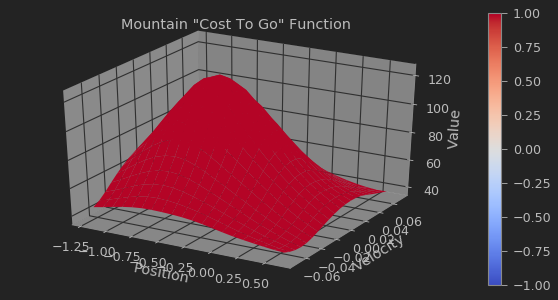

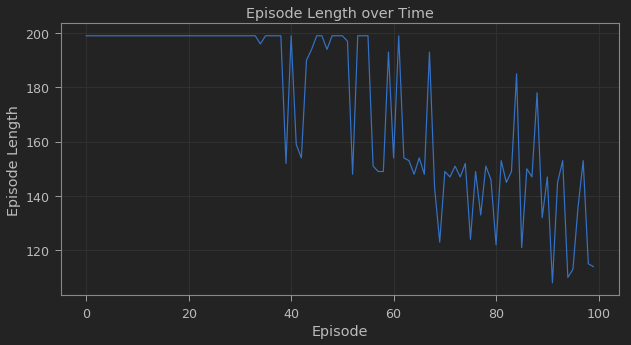

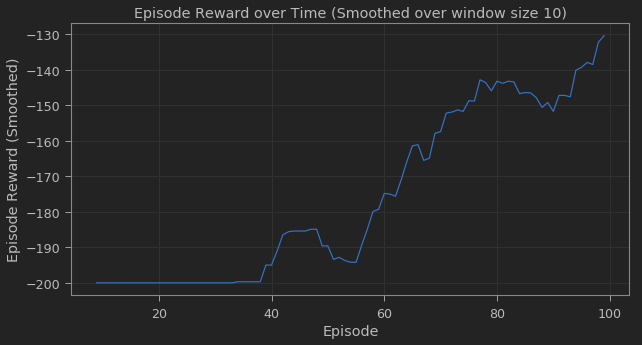

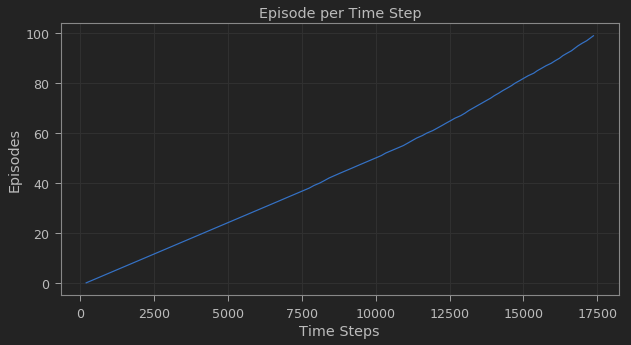

(<matplotlib.figure.Figure at 0x7ff87fe41a58>,
 <matplotlib.figure.Figure at 0x7ff87fcd9080>)

In [20]:
plot_cost_to_go_mountain_car(env, estimator)
plot_episode_stats(stats)